#Import & functions

In [1]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import cv2
import shutil
import itertools
import random
from PIL import Image
from pathlib import Path
from skimage.color import rgb2gray

from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import MeanIoU
from keras.models import load_model
from keras import backend as K

In [3]:
from numpy.random import seed
seed(1305)
tf.random.set_seed(1305)

In [4]:
def searching_all_files(directory: Path):   
    file_list = [] # A list for storing files existing in directories

    for x in directory.iterdir():
        if x.is_file():

           file_list.append(str(x))
        else:

           file_list.append(searching_all_files(directory/x))

    return file_list

In [5]:
def flatten(listOfLists):
    "Flatten one level of nesting"
    return list(itertools.chain.from_iterable(listOfLists))

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Parameters

In [7]:
lr = 0.001
n_epochs = 1000
n_batch = 8
pre_processing = False
HE = True
Prcc = True
Crcc = False
CrCCPrCC = False
Patch = False

# Train/Test

In [ ]:
if pre_processing:
  original_dataset = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Original/train_Pr_clahed.npy')
  original_dataset_test = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Original/test_Pr_clahed.npy')
  segm_dataset = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Mask/train_Pr_mask_BIN.npy')
  segm_dataset_test = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Mask/test_Pr_mask_BIN.npy')

In [ ]:
if HE:
  if Prcc:
    original_dataset = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Original/train_Pr_norm.npy')
    original_dataset_test = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Original/test_Pr_norm.npy')
    segm_dataset = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Mask/train_Pr_mask_BIN.npy')
    segm_dataset_test = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Mask/test_Pr_mask_BIN.npy')
  elif Crcc:
    original_dataset = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Original/train_Cr_norm.npy')
    original_dataset_test = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Original/test_Cr_norm.npy')
    segm_dataset = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Mask/train_Cr_mask_BIN.npy')
    segm_dataset_test = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Mask/test_Cr_mask_BIN.npy')
  elif CrCCPrCC:
    original_dataset = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Original/train_PrCr_norm.npy')
    original_dataset_test = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Original/test_PrCr_norm.npy')
    segm_dataset = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Mask/train_PrCr_mask_BIN.npy')
    segm_dataset_test = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Mask/test_PrCr_mask_BIN.npy')

In [ ]:
if pre_processing == False and HE == False and Patch == False:
  original_dataset = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Original/train_Pr_original.npy')
  original_dataset_test = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Original/test_Pr_original.npy')
  segm_dataset = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Mask/train_Pr_mask_BIN.npy')
  segm_dataset_test = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Mask/test_Pr_mask_BIN.npy')

In [ ]:
if Patch == True:
  original_dataset = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Patches/train_original.npy')
  original_dataset_test = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Patches/test_original.npy')
  segm_dataset = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Patches/train_mask.npy')
  segm_dataset_test = np.load('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Patches/test_mask.npy')

In [ ]:
X_train = original_dataset
X_test = original_dataset_test
y_train = segm_dataset
y_test = segm_dataset_test

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.20, random_state = 42)

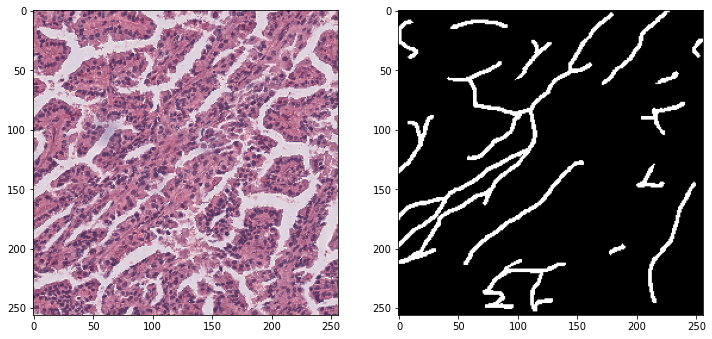

In [ ]:
#Sanity check, view few mages
import random

image_number = random.randint(0, len(X_train)-1) 
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,:])
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0],cmap='gray')
plt.show()

# Architecture Autoencoder

In [8]:
def jacard_coef(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def jacard_coef_loss(y_true, y_pred):
  return -jacard_coef(y_true, y_pred)

In [9]:
input_img = keras.Input(shape=(256, 256, 3))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x) 

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.ZeroPadding2D(padding=(2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x) 

opt = keras.optimizers.Adam(learning_rate=lr)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer=opt, loss=[jacard_coef_loss], metrics=[jacard_coef])

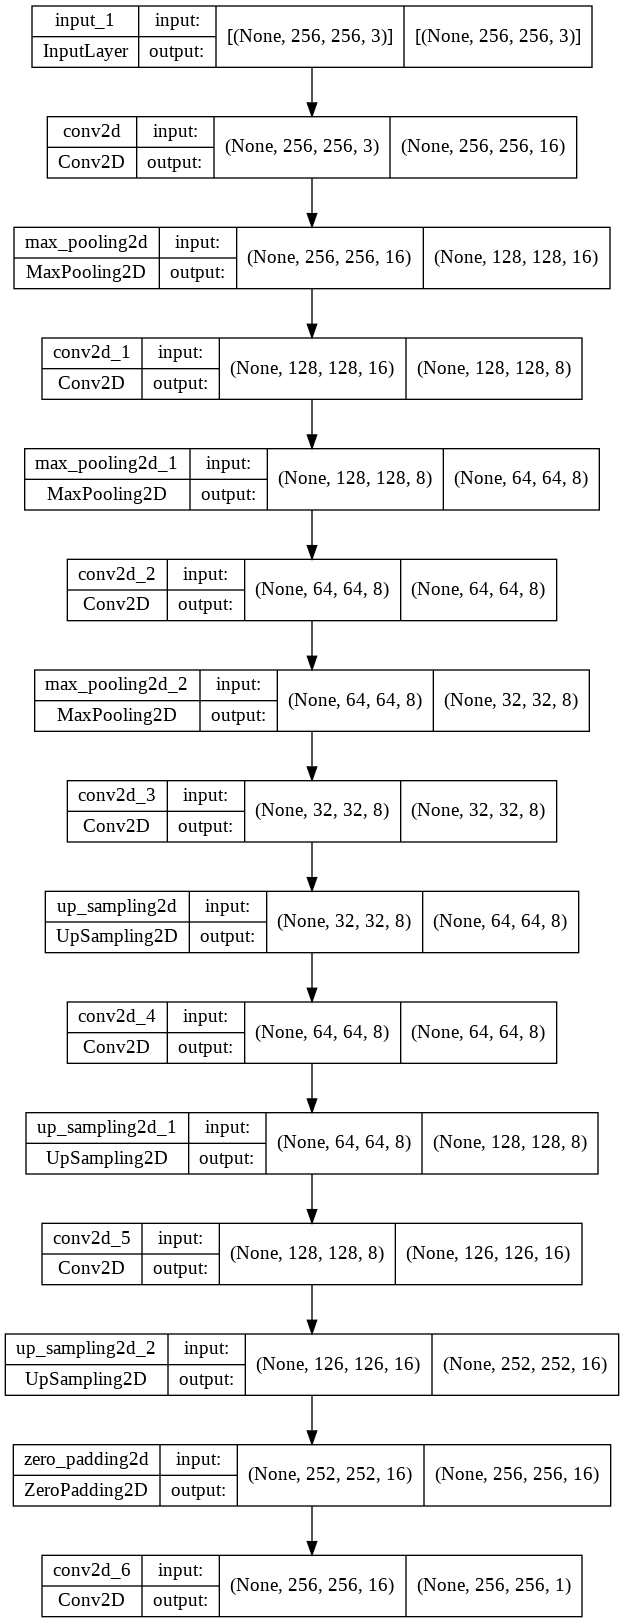

In [10]:
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)

In [11]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 8)       1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 8)         584   

In [ ]:
storico = autoencoder.fit(X_train, y_train,
                epochs=n_epochs,
                batch_size=n_batch,
                verbose = 1,
                shuffle=True,
                validation_data=(X_valid,y_valid))

Epoch 1/1000
10/10 [==============================] - 4s 57ms/step - loss: -0.1117 - jacard_coef: 0.1117 - val_loss: -0.1257 - val_jacard_coef: 0.1231
Epoch 2/1000
10/10 [==============================] - 0s 23ms/step - loss: -0.1206 - jacard_coef: 0.1206 - val_loss: -0.1317 - val_jacard_coef: 0.1288
Epoch 3/1000
10/10 [==============================] - 0s 29ms/step - loss: -0.1224 - jacard_coef: 0.1224 - val_loss: -0.1315 - val_jacard_coef: 0.1287
Epoch 4/1000
10/10 [==============================] - 0s 28ms/step - loss: -0.1223 - jacard_coef: 0.1223 - val_loss: -0.1316 - val_jacard_coef: 0.1287
Epoch 5/1000
10/10 [==============================] - 0s 23ms/step - loss: -0.1224 - jacard_coef: 0.1224 - val_loss: -0.1319 - val_jacard_coef: 0.1290
Epoch 6/1000
10/10 [==============================] - 0s 23ms/step - loss: -0.1227 - jacard_coef: 0.1227 - val_loss: -0.1324 - val_jacard_coef: 0.1293
Epoch 7/1000
10/10 [==============================] - 0s 22ms/step - loss: -0.1252 - jacard_co

#Losses

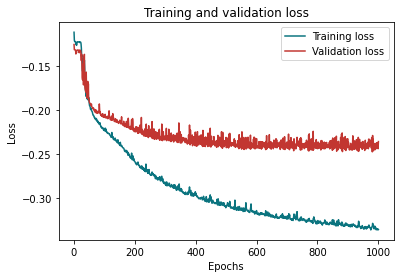

In [ ]:
loss = storico.history['loss']
val_loss = storico.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, '#0b747f', label='Training loss')
plt.plot(epochs, val_loss, '#c23631', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Save the model

In [ ]:
#Save the model for future use
autoencoder.save('/content/drive/MyDrive/Bioinfo/modelli_salvati/Autoencoder/FINAL_Autoencoder_Pr_norm_8batch_LR1e-3.hdf5')

#Predict and Plot

In [ ]:
#autoencoder = load_model('/content/drive/MyDrive/Bioinfo/modelli_salvati/Autoencoder/FINAL_Autoencoder_Pr_norm_8batch_LR1e-3.hdf5',custom_objects={'jacard_coef_loss': jacard_coef_loss,'jacard_coef':jacard_coef})

In [ ]:
threshold = 0.5
y_pred=autoencoder.predict(X_test)
y_pred_thresholded = y_pred > threshold

In [ ]:
#___________ MEAN IOU__________________
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.53378814


In [ ]:
#_____________ IOU____________________
intersection = np.logical_and(y_test,y_pred_thresholded)
union=np.logical_or(y_test,y_pred_thresholded)
iou_score = np.sum(intersection)/np.sum(union)
print("IoU score is:",iou_score)

IoU score is: 0.2709558996564221


In [ ]:
#_____________ DICE____________________
intersection = np.logical_and(y_test,y_pred_thresholded)
union=np.logical_or(y_test,y_pred_thresholded)
dice_score = (2*np.sum(intersection))/(np.sum(union)+np.sum(intersection))
print("Dice score is:", dice_score)

Dice score is: 0.4263812768478744


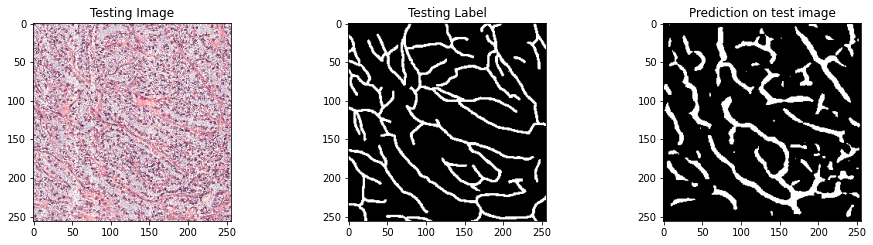

In [ ]:
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (autoencoder.predict(test_img_input)[0,:,:,0] > threshold).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,:])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)

plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

# Overlapping

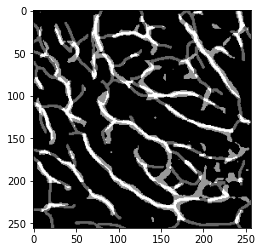

In [ ]:
fig, ax = plt.subplots()
ax.imshow(ground_truth[:,:,0], cmap='gray')
ax.imshow(prediction,cmap='gray', alpha=0.6)
fig.show()

# Plot all test images

In [ ]:
def plot_images(test_images, ground_truth, prediction, i):
  plt.figure()
  i = i+1
  titolo = 'Testing Image '+str(i)
  plt.title(titolo)
  plt.imshow(test_img[:,:,:])
  plt.show()

def plot_overlapping(ground_truth, prediction, i):
  fig, ax = plt.subplots()
  ax.imshow(ground_truth[:,:,0], cmap='gray')
  ax.imshow(prediction,cmap='gray', alpha=0.6)
  i = i+1
  titolo = 'Masks Overlapping '+str(i)
  ax.set_title(titolo)
  fig.show() 

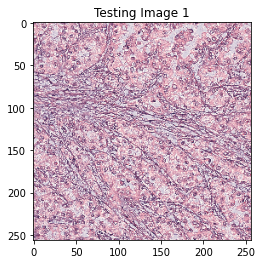

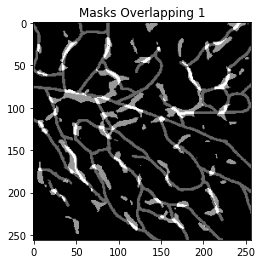

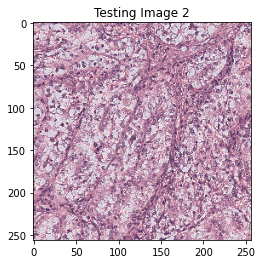

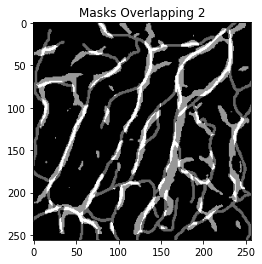

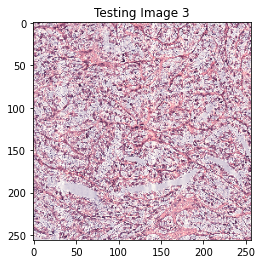

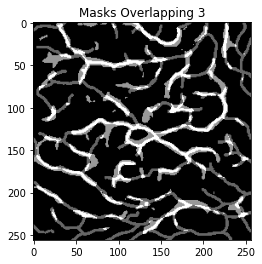

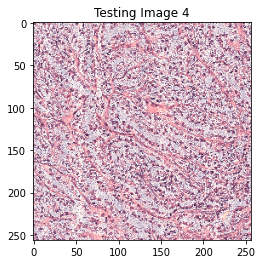

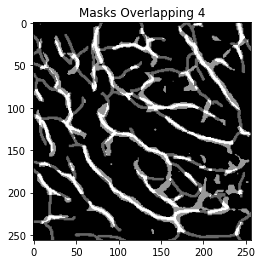

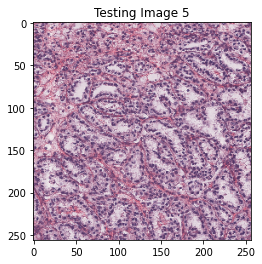

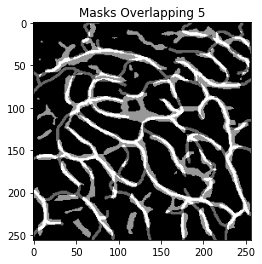

In [ ]:
for i in range(len(X_test)):
  test_img_number = i
  test_img = X_test[test_img_number]
  ground_truth=y_test[test_img_number]
  test_img_input=np.expand_dims(test_img, 0)
  prediction = (autoencoder.predict(test_img_input)[0,:,:,0] > threshold).astype(np.uint8)
  
  plot_images(test_img, ground_truth, prediction, i)
  plot_overlapping(ground_truth, prediction, i)